Kmeans and Hierarchical clustering

## Imports

In [210]:
import pandas as pd
import sklearn as sk
import numpy as np

In [211]:
df = pd.read_csv('./assets/ligue1_17_18.csv', sep=';')

In [212]:
df.head(2)

,Team,Points,Wins,Draws,Loses,Goals.scored,Goals.conceded,Difference.goals,Points.per.game,red.cards,...,clean.sheets.percentage,failed.to.score.percentage,shots.per.match.average,shots.on.goal.per.match.average,ball.possession.per.game.average,sum.offside.in.attack,sum.offside.in.defense,corners.per.game.average,fouls.for.sum,fouls.against.sum
0,Paris-SG,93,29,6,3,108,29,79,2.45,6,...,47,8,16.05,6.74,63.34,98,99,6.71,139,105
1,Monaco,80,24,8,6,85,45,40,2.11,3,...,37,11,15.68,3.18,57.68,93,90,6.39,115,112


In [213]:
'We have ' + str(len(df.columns)) + ' features'

'We have 21 features'

## K-Means on small dataset

We only use 2 features to test K-Means on this dataset, we keep `Points` & `yellow.cards`

In [214]:
points_cards = df[['Points', 'yellow.cards']]
points_cards.head()

,Points,yellow.cards
0,93,66
1,80,70
2,78,70
3,77,79
4,58,63


In [215]:
from sklearn.cluster import KMeans

def create_kmeans_model(k: int = 2) -> KMeans:
    """Creates a KMeans model

    Args:
        k (int): The number of clusters to create

    Returns:
        (KMeans): The model you created
    """
    return KMeans(n_clusters=k, max_iter=20, random_state=0)

### k=2

In [216]:
km = create_kmeans_model(2)
clusters = km.fit_predict(points_cards)

We see the parameters of the KMeans model.

In [217]:
km.cluster_centers_ 

array([[44.75  , 71.5625],
       [82.    , 71.25  ]])

We can see that we have 2 points in a 2D space as we used `k=2`, each representing the centroid of a cluster

In [218]:
import matplotlib.pyplot as plt

In [219]:
len(clusters)

20

In [220]:
for centroid in km.cluster_centers_:
    print(centroid)

[44.75   71.5625]
[82.   71.25]


Plot with clusters, centroids & labels

In [221]:
from sklearn.cluster import KMeans

def plot_clusters(model: KMeans, clusters: np.ndarray, df: pd.DataFrame, title: str) -> None:
    """Plots clusters of a KMeans model along with its centroids

    Args:
        model (KMeans): The model containing informations
        clusters (ndarray): The column with the clusters
        df (DataFrame): The DataFrame with the features
        title (str): The title of the plot
    """
    plt.scatter(x=df['Points'], y=df['yellow.cards'], c=clusters)
    plt.xlabel('Points')
    plt.ylabel('yellow.cards')
    plt.title(title)
    
    for centroid in model.cluster_centers_:
        plt.scatter(x=centroid[0], y=centroid[1], c='red', marker='x')
    
    for i, team in enumerate(df['Team']):
        plt.annotate(team, (df['Points'][i], df['yellow.cards'][i]), fontsize=7)

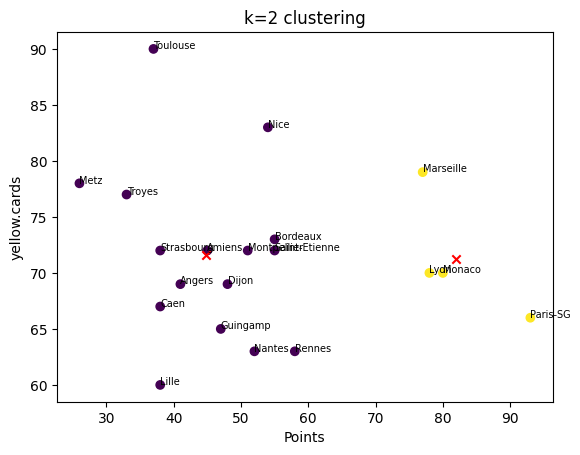

In [222]:
plot_clusters(km, clusters, df, 'k=2 clustering')

We probably need a higher value of K as `Toulouse` is very far from its centroid

### k=3

In [223]:
km3 = create_kmeans_model(3)
clusters_3 = km3.fit_predict(points_cards)

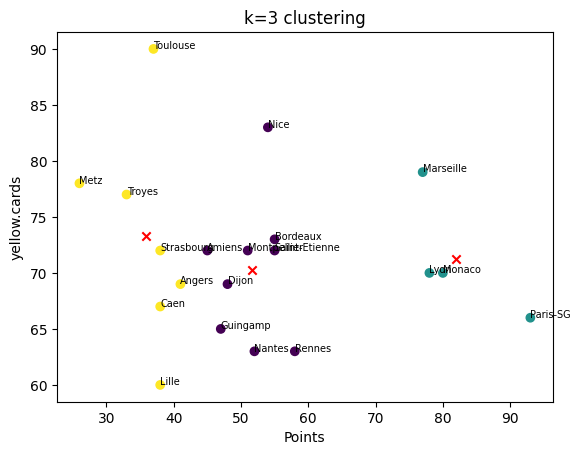

In [224]:
plot_clusters(km3, clusters_3, df, 'k=3 clustering')

We are getting better results but `Nice` is still an example of high inertia

### k=4

In [225]:
km4 = create_kmeans_model(4)
clusters_4 = km4.fit_predict(points_cards)

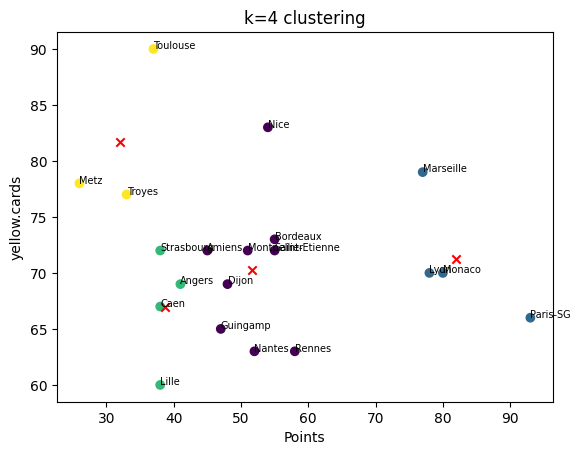

In [226]:
plot_clusters(km4, clusters_4, df, 'k=4 clustering')

We can see that the points are very spread out and that we can still minimize the inertia

## Check scores between the different K-values

In [227]:
df.columns[10]

'yellow.cards'

In [228]:
import matplotlib.pyplot as plt

def plot_within_clusters(kmeans: KMeans, clusters: np.ndarray, df: pd.DataFrame, title: str) -> None:
    """Plots clusters of a KMeans model with intra-

    Args:
        model (KMeans): The model containing informations
        clusters (ndarray): The column with the clusters
        df (DataFrame): The DataFrame with the features
        title (str): The title of the plot
    """
    temp_df = df.copy()
    temp_df['Cluster'] = clusters

    colors = ['g', 'b', 'y', 'c', 'm', 'k', 'orange', 'purple', 'brown', 'pink']

    for i in range(kmeans.n_clusters):
        # Add points of cluster i
        cluster_points = temp_df[temp_df['Cluster'] == i]
        plt.scatter(cluster_points.iloc[:, 1], cluster_points.iloc[:, 10], c=colors[i], label=f'Cluster {i+1}')

        # Add centroid
        centroid = kmeans.cluster_centers_[i]
        plt.scatter(centroid[0], centroid[1], c='red', marker='x')

        # Add lines from each points to the centroid
        for j in range(len(cluster_points)):
            plt.plot([centroid[0], cluster_points.iloc[j, 1]], 
                     [centroid[1], cluster_points.iloc[j, 10]], 
                     c=colors[i], linestyle='--', linewidth=0.5)

    plt.title(title)
    plt.xlabel(df.columns[1])
    plt.ylabel(df.columns[10])
    plt.legend()
    plt.show()

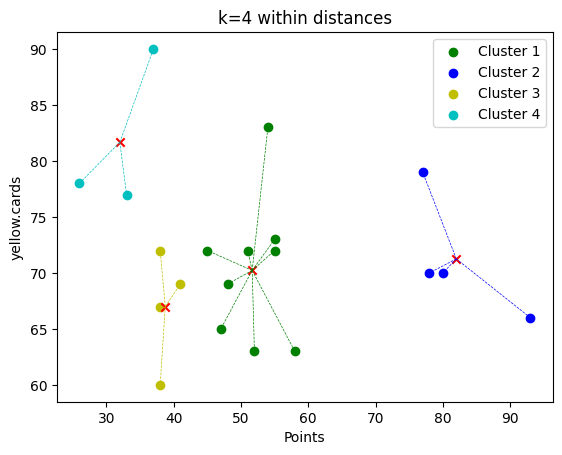

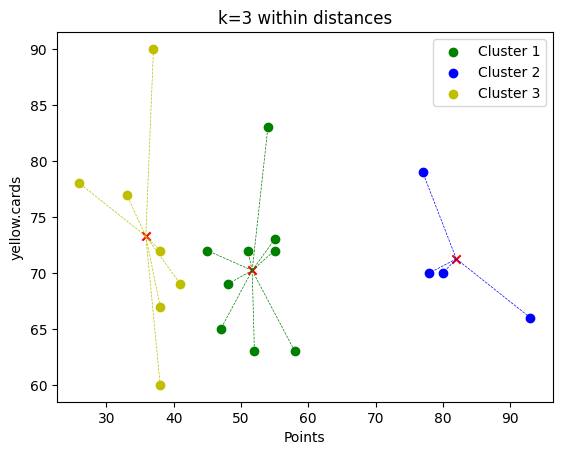

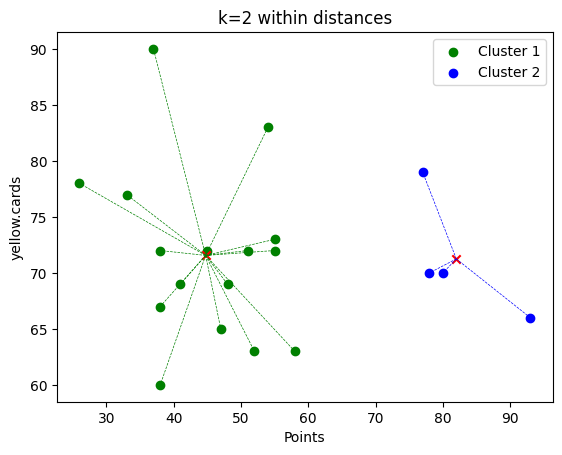

In [229]:
plot_within_clusters(km4, clusters_4, df, 'k=4 within distances')
plot_within_clusters(km3, clusters_3, df, 'k=3 within distances')
plot_within_clusters(km, clusters, df, 'k=2 within distances')

In [230]:
def get_squared_distance(point_a, point_b):
    return (point_a[0]-point_b[0])**2 + (point_a[1]-point_b[1])**2 

def get_total_wci(df: pd.DataFrame, centroids: list) -> int:
    """Calculate the Total Within Cluster Inertia. It represents the sum of distances between each point of a given cluster
    and its centroid.

    Args:
        df (DataFrame): The data to calculate it from.
        clusters (List): List of coordinates of centroids

    Returns:
        int: Total Within Cluster Inertia
    """
    clusters = df.clusters.unique()
    total_wsd = 0
    
    for cluster in clusters:
        df_class = df[df["clusters"] == cluster]
        for i in range(df_class.shape[0]):
            point = [df_class.iloc[i,0], df_class.iloc[i,1]]
            total_wsd += get_squared_distance(centroids[cluster], point)

    return total_wsd

def get_total_bci(df: pd.DataFrame, centroids: list) -> int:
    """Calculate the Total Between Cluster Inertia. It represents to sum of the distances between each centroid
    and the sample mean.

    Args:
        df (DataFrame): The data to calculate it from.
        clusters (List): List of coordinates of centroids

    Returns:
        int: Total Between Cluster Inertia
    """
    total_bci = 0

    sample_mean = [df['yellow.cards'].sum()/df.shape[0], df['Points'].sum()/df.shape[0]]

    for centroid in centroids:
        total_bci += get_squared_distance(centroid, sample_mean)

    return total_bci

def get_total_inertia(df: pd.DataFrame) -> int:
    """Calculate the Total Inertia. It represents to sum of the distances between each points of the dataset
    and the sample mean.

    Args:
        df (DataFrame): The data to calculate it from.

    Returns:
        int: Total Inertia
    """
    total_inertia = 0

    sample_mean = [df['yellow.cards'].sum()/df.shape[0], df['Points'].sum()/df.shape[0]]

    for i in range(df.shape[0]):
        point = [df.iloc[i,0], df.iloc[i,1]]
        total_inertia += get_squared_distance(sample_mean, point)

    return total_inertia

In [231]:
import seaborn as sns

within_cluster_inertia = []
between_cluster_inertia = []
total_inertia = get_total_inertia(points_cards)
min_k = 2
max_k = 20 + 1


for i in range(min_k, max_k):
    model = create_kmeans_model(i)
    clusters = model.fit_predict(points_cards)
    temp_df = points_cards.copy()
    temp_df['clusters'] = clusters
    within_cluster_inertia.append(get_total_wci(temp_df, model.cluster_centers_))
    between_cluster_inertia.append(get_total_bci(temp_df, model.cluster_centers_))


Text(0.5, 1.0, 'Total Within Cluster Inertia / Total Inertia by Number of Clusters')

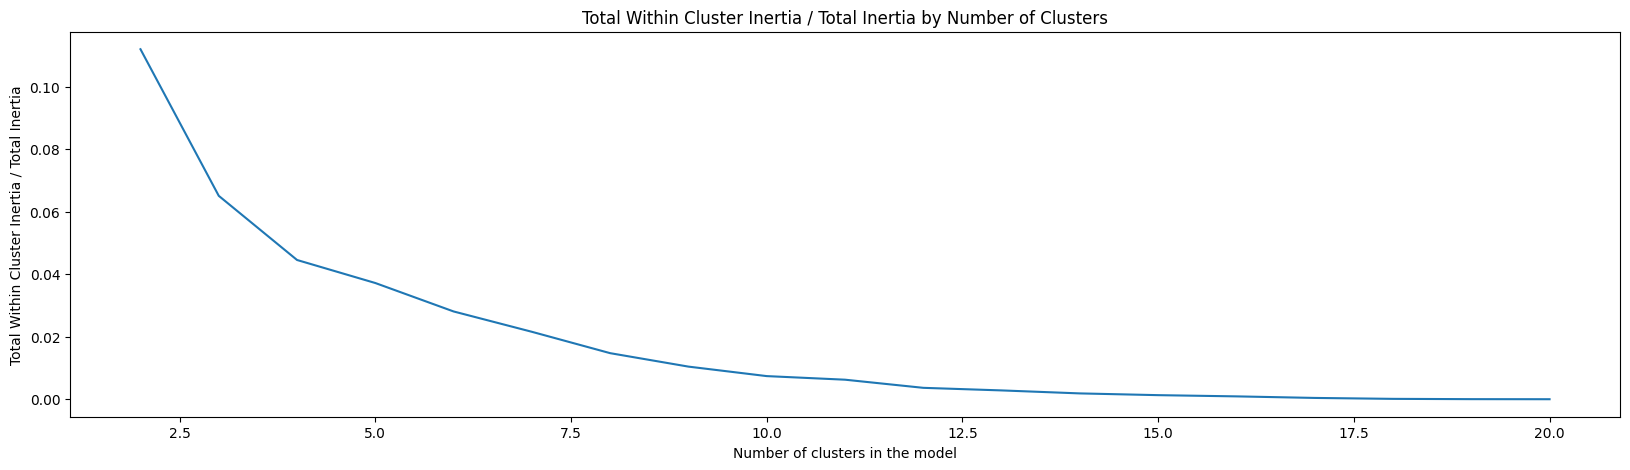

In [232]:
fig = plt.figure(figsize=(20, 5))
sns.lineplot(x=range(min_k, max_k), y=within_cluster_inertia/total_inertia)
plt.xlabel("Number of clusters in the model")
plt.ylabel("Total Within Cluster Inertia / Total Inertia")
plt.title("Total Within Cluster Inertia / Total Inertia by Number of Clusters")

We can tell that a significant change happens around K=3. Of course, the more clusters we use, we more it overfits data. Overfitting in KMeans decreases the total inertia as the number of centroid approaches the number of points. We see that when K = Number Of Individuals, we get a WCI ratio of 1.

Text(0.5, 1.0, 'Total Between Cluster Inertia / Total Inertia by Number of Clusters')

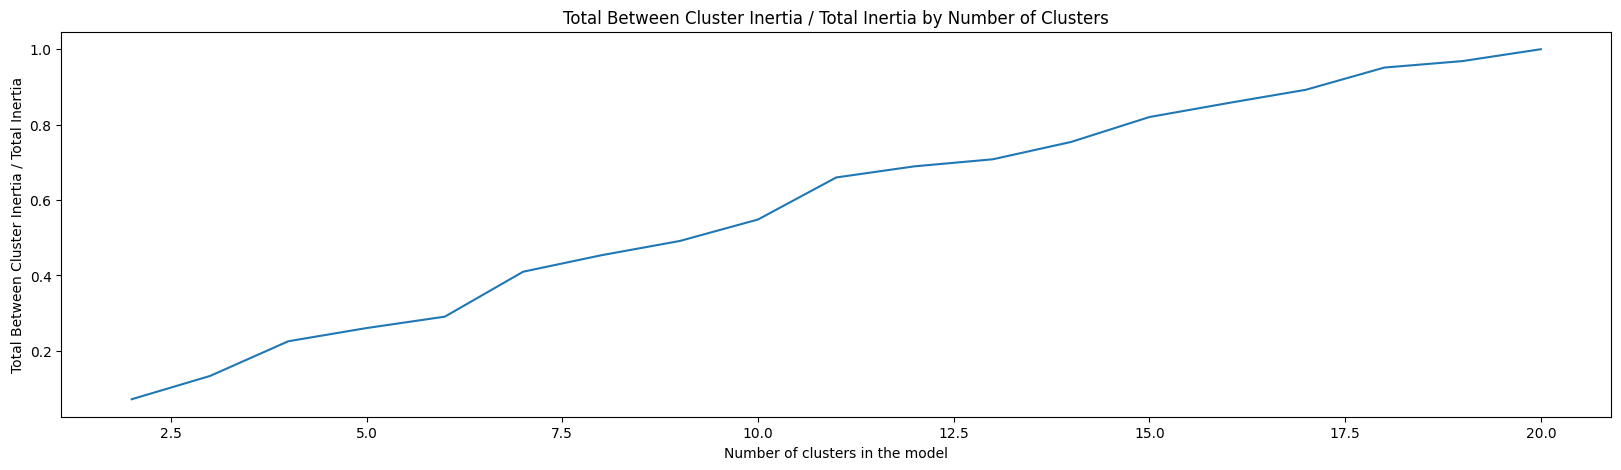

In [233]:
fig = plt.figure(figsize=(20, 5))
sns.lineplot(x=range(min_k, max_k), y=between_cluster_inertia/total_inertia)
plt.xlabel("Number of clusters in the model")
plt.ylabel("Total Between Cluster Inertia / Total Inertia")
plt.title("Total Between Cluster Inertia / Total Inertia by Number of Clusters")

We can spot a slight decrease in the rate of change of this function at K=4. It is normal for the Distance Between Clusters to increase while K increases as it creates more centroids. We see that when K = `Number Of Individuals`, we get a BCI ratio of 1.

## Data Preprocessing

In [234]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

In [235]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 21 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Team                              20 non-null     object 
 1   Points                            20 non-null     int64  
 2   Wins                              20 non-null     int64  
 3   Draws                             20 non-null     int64  
 4   Loses                             20 non-null     int64  
 5   Goals.scored                      20 non-null     int64  
 6   Goals.conceded                    20 non-null     int64  
 7   Difference.goals                  20 non-null     int64  
 8   Points.per.game                   20 non-null     float64
 9   red.cards                         20 non-null     int64  
 10  yellow.cards                      20 non-null     int64  
 11  clean.sheets.percentage           20 non-null     int64  
 12  failed.to.

In [236]:
df_scaled = df.copy()
df_scaled[df.columns[1:]] = scaler.fit_transform(df[df.columns[1:]])

df_scaled.head()

,Team,Points,Wins,Draws,Loses,Goals.scored,Goals.conceded,Difference.goals,Points.per.game,red.cards,...,clean.sheets.percentage,failed.to.score.percentage,shots.per.match.average,shots.on.goal.per.match.average,ball.possession.per.game.average,sum.offside.in.attack,sum.offside.in.defense,corners.per.game.average,fouls.for.sum,fouls.against.sum
0,Paris-SG,2.378453,2.513897,-1.356801,-1.936222,2.678093,-1.875636,2.782656,2.376637,0.894737,...,1.921859,-1.560024,2.359751,2.900663,2.583806,1.921895,0.891620,2.535370,2.981012,0.128452
1,Monaco,1.620612,1.664607,-0.603023,-1.417591,1.584994,-0.550683,1.408940,1.625655,-0.684211,...,0.936290,-1.320634,2.146850,-1.146509,1.488678,1.488059,0.544986,2.088486,0.985355,0.601695
2,Lyon,1.504022,1.494749,-0.226134,-1.417591,1.680046,-0.716302,1.549834,1.493129,-1.210526,...,1.133404,-1.320634,1.496638,2.150345,1.235212,1.140990,0.005777,1.180752,0.902203,0.263664
3,Marseille,1.445726,1.324892,0.527645,-1.590468,1.347364,-0.385064,1.162375,1.448954,-0.684211,...,0.936290,-1.560024,0.483919,-0.600823,1.142339,0.967455,-0.302342,0.622147,0.735898,-1.223671
4,Rennes,0.338113,0.305744,0.150756,-0.380329,-0.078418,-0.633493,0.211341,0.344568,0.368421,...,-0.147835,-1.161041,0.299788,-0.123348,0.503836,0.880688,-0.726006,0.594217,0.569594,0.939726


In [237]:
km_ligue1 = create_kmeans_model(3)
km_ligue1_res = km_ligue1.fit_predict(df[df.columns[1:]])

km_ligue1_scaled = create_kmeans_model(3)
km_ligue1_scaled_res = km_ligue1_scaled.fit_predict(df_scaled[df.columns[1:]])

We can check if the data is the same whether we use scaled or unscaled data

In [238]:
km_ligue1_res, km_ligue1_scaled_res

(array([2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0]),
 array([2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0]))

In [239]:
np.bincount(km_ligue1_res), np.bincount(km_ligue1_scaled_res)

(array([ 6, 10,  4], dtype=int64), array([ 6, 10,  4], dtype=int64))

We easily see that the clusters are differently shaped when we use scaled data

## PCA

To visualize the data, we can use PCA to reduce the dimensionality of the data. We have to use it on the scaled data as we need a variance of 1 to get the best results.

In [240]:
from sklearn.decomposition import PCA

pca_ligue1 = PCA(n_components=2)
df_pca_scaled = pca_ligue1.fit_transform(df_scaled[df.columns[1:]])

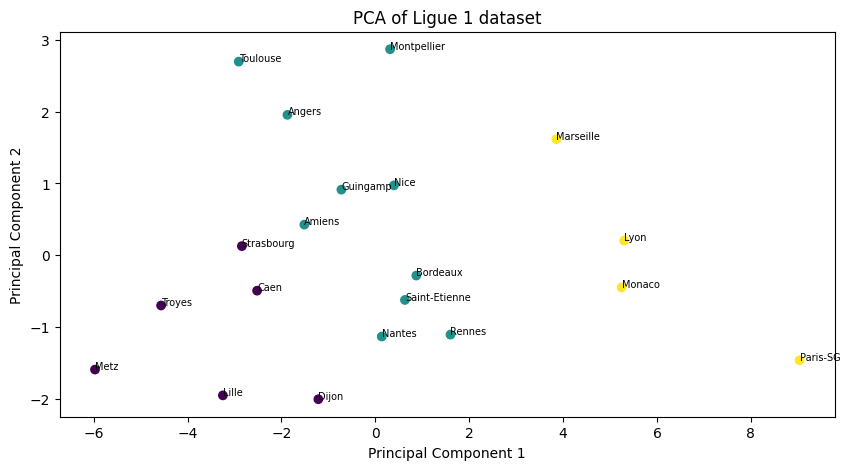

In [241]:
plt.figure(figsize=(10, 5))
plt.scatter(df_pca_scaled[:, 0], df_pca_scaled[:, 1], c=km_ligue1_res)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Ligue 1 dataset')

for i, team in enumerate(df['Team']):
    plt.annotate(team, (df_pca_scaled[i, 0], df_pca_scaled[i, 1]), fontsize=7)

We used the 20 features from the original dataset to create KMeans clusters. Then, we used PCA to reduce the dimensionality to 2 features and added the clusters to the plot with the 3rd dimension (colors).

Now, we will use PCA on the dataset, then we will use KMeans on the PCA dataset to see if we can get better results.

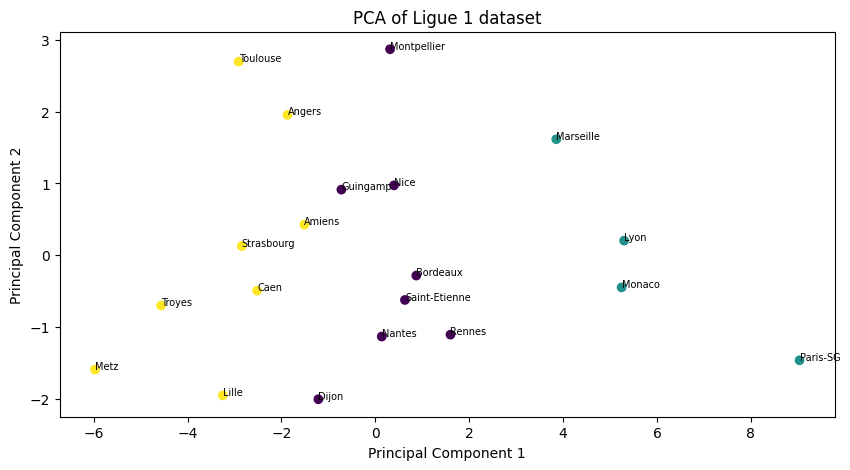

In [242]:
pca = PCA(n_components=2)
df_pca_scaled = pca.fit_transform(df_scaled[df.columns[1:]])

km_pca = create_kmeans_model(3)
km_pca_res = km_pca.fit_predict(df_pca_scaled)

plt.figure(figsize=(10, 5))
plt.scatter(df_pca_scaled[:, 0], df_pca_scaled[:, 1], c=km_pca_res)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Ligue 1 dataset')

for i, team in enumerate(df['Team']):
    plt.annotate(team, (df_pca_scaled[i, 0], df_pca_scaled[i, 1]), fontsize=7)

Using KMeans on the dimensionality-reduced data, we can results that make more sense when plotted in a 2 dimensional space. But, one can imagine that in higher dimensions, the clusters are less relevant.

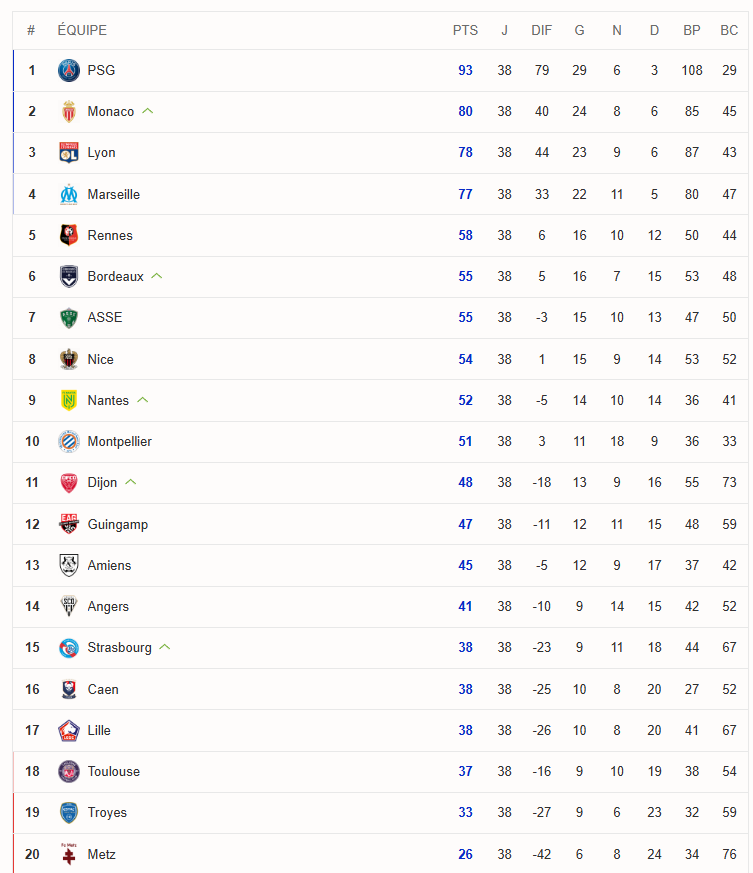

But if we stick to the rankings of the 2017-2018 of Ligue 1, we can see that PCA -> KMeans is more result oriented than KMeans -> PCA at clustering teams. If we check some features like DIFF of Toulouse (which have a pretty good DIFF for a such a ranking) or the DIFF of Dijon (which have a terrible DIFF for such a high ranking), we can see that KMeans -> PCA did take that into account and did not cluster Toulouse with the bad teams and Dijon with the good ones.

## KMeans from Scratch

In [243]:
k = 2 # Clusters
n = 6 # Observations
p = 2 # Features

In [244]:
observations = [1, 2, 3, 4, 5, 6]
X_1 = np.array([1,1,0,5,6,4])
X_2 = np.array([4,3,4,1,2,0])

Text(0.5, 1.0, 'Observations')

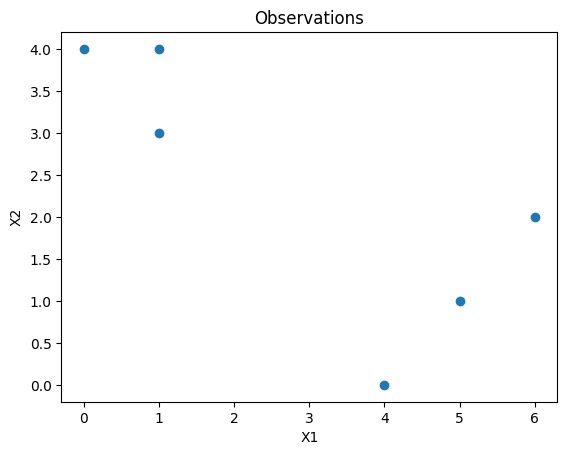

In [246]:
plt.scatter(X_1, X_2)
plt.xlabel('X1')
plt.ylabel('X2')
plt.title('Observations')

1. We randomly assign a cluster label to each point.

In [248]:
clusters = np.array(np.random.randint(0, k, n))
clusters

array([1, 1, 0, 1, 0, 0])

2. Compute centroids of clusters.

In [252]:
def get_euclidean_distance(point_a: np.ndarray, point_b: np.ndarray) -> float:
    """Calculates the Euclidean distance between two points.

    Args:
        point_a (ndarray): The first point
        point_b (ndarray): The second point

    Returns:
        float: The Euclidean distance
    """
    return np.sqrt(np.sum((point_a - point_b) ** 2))

def get_centroids(X: np.ndarray, clusters: np.ndarray, k: int) -> np.ndarray:
    """Calculates the centroids of the clusters. Using Euclidean distance.

    Args:
        X (ndarray): The data
        clusters (ndarray): The cluster of each observation
        k (int): The number of clusters

    Returns:
        ndarray: The centroids
    """
    centroids = np.zeros((k, X.shape[1]))

    for i in range(k):
        cluster_points = X[clusters == i]
        centroids[i] = np.mean(cluster_points, axis=0)

    return centroids

centroids = get_centroids(np.array([X_1, X_2]).T, clusters, k)
centroids

array([[3.33333333, 2.        ],
       [2.33333333, 2.66666667]])

Text(0.5, 1.0, 'Observations with centroids')

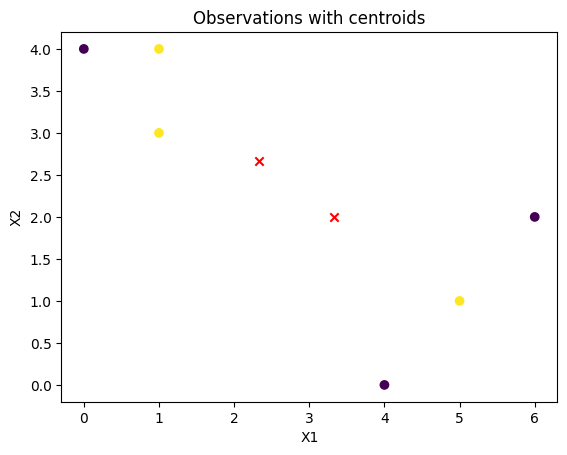

In [253]:
plt.scatter(X_1, X_2, c=clusters)
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='x')
plt.xlabel('X1')
plt.ylabel('X2')
plt.title('Observations with centroids')

This plot shows centroids of each cluster

3. Assign each point to the closest cluster centroid.

In [256]:
def assign_points_to_centroids(X: np.ndarray, centroids: np.ndarray) -> np.ndarray:
    """Assigns each point to the closest centroid.

    Args:
        X (ndarray): The data
        centroids (ndarray): The centroids

    Returns:
        ndarray: The cluster of each point
    """
    clusters = np.zeros(X.shape[0])

    for i, point in enumerate(X):
        distances = [get_euclidean_distance(point, centroid) for centroid in centroids]
        clusters[i] = np.argmin(distances)

    return clusters

clusters = assign_points_to_centroids(np.array([X_1, X_2]).T, centroids)

Text(0.5, 1.0, 'Observations with centroids')

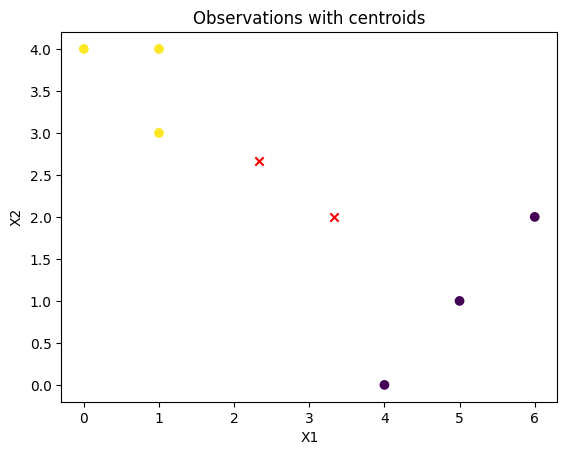

In [259]:
plt.scatter(X_1, X_2, c=clusters)
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='x')
plt.xlabel('X1')
plt.ylabel('X2')
plt.title('Observations with centroids')

Plot of observations after each point being assigned to the closest centroid

4. Rinse and repeat until convergence

Text(0.5, 1.0, 'End-state of the algorithm')

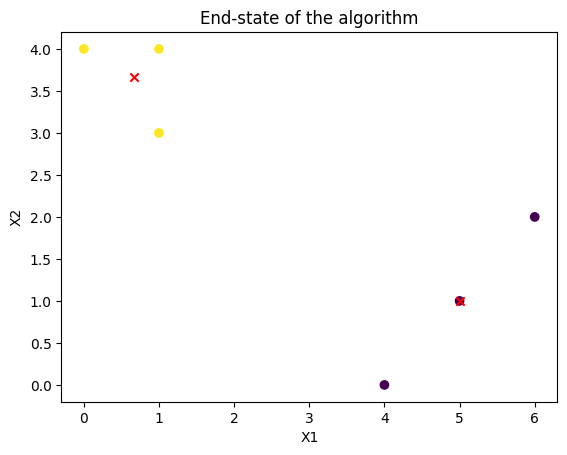

In [264]:
i=1
while True:
    # Assign points to the closest centroid
    clusters = assign_points_to_centroids(np.array([X_1, X_2]).T, centroids)

    # Calculate the middle of each cluster (new centroids)
    new_centroids = get_centroids(np.array([X_1, X_2]).T, clusters, k)

    # If the centroids don't change, we stop
    if np.array_equal(centroids, new_centroids):
        break

    centroids = new_centroids

    print(f'Iteration {i}')


plt.scatter(X_1, X_2, c=clusters)
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='x')
plt.xlabel('X1')
plt.ylabel('X2')
plt.title('End-state of the algorithm')


## Hierarchical clustering

We have to use Iris Dataset now

In [295]:
df_iris = pd.read_csv('./assets/iris.data')

In [296]:
df_iris.head()

,sepal_length,sepal_width,petal_length,petal_width,class
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


We randomly choose `40` samples.

In [297]:
sampleiris = df_iris.sample(40, random_state=0)
sampleiris.shape

(40, 5)

Calculate the euclidian distance between the flowers

In [298]:
D = np.zeros((40, 40))

for i in range(40):
    for j in range(40):
        D[i, j] = get_euclidean_distance(sampleiris.iloc[i, :-1], sampleiris.iloc[j, :-1])

D

array([[0.        , 1.88944436, 4.53651849, ..., 0.83066239, 1.2922848 ,
        1.64012195],
       [1.88944436, 0.        , 3.41320963, ..., 1.34907376, 0.96953597,
        0.48989795],
       [4.53651849, 3.41320963, 0.        , ..., 4.26028168, 3.33616546,
        3.22645316],
       ...,
       [0.83066239, 1.34907376, 4.26028168, ..., 0.        , 0.9591663 ,
        1.19163753],
       [1.2922848 , 0.96953597, 3.33616546, ..., 0.9591663 , 0.        ,
        0.54772256],
       [1.64012195, 0.48989795, 3.22645316, ..., 1.19163753, 0.54772256,
        0.        ]])

C:\Users\nicol\AppData\Local\Temp\ipykernel_18296\1640242687.py:3: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  dendro_avg = dendrogram(linkage(D, method='average'), labels=sampleiris.index, orientation='right')


Text(0.5, 1.0, 'Dendrogram with average linkage')

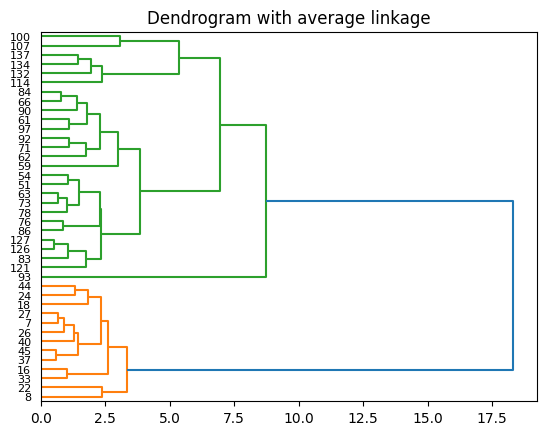

In [299]:
from scipy.cluster.hierarchy import dendrogram, linkage

dendro_avg = dendrogram(linkage(D, method='average'), labels=sampleiris.index, orientation='right')
plt.title('Dendrogram with average linkage')

In [300]:
from scipy.cluster.hierarchy import fcluster

groups_avg = fcluster(linkage(D, method='average'), 3, criterion='maxclust')
groups_avg

C:\Users\nicol\AppData\Local\Temp\ipykernel_18296\2005069371.py:3: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  groups_avg = fcluster(linkage(D, method='average'), 3, criterion='maxclust')


array([2, 2, 1, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 1, 2, 2,
       1, 1, 2, 1, 1, 2, 3, 1, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2], dtype=int32)

In [301]:
print(pd.crosstab(sampleiris['class'], groups_avg))

col_0        1   2  3
class                
setosa      13   0  0
versicolor   0  17  1
virginica    0   9  0


We can see that the clustering is not very good at classifying `Virginica` flowers. On the other hand, it succesfully has 100% accuracy on `Setosa`.

### Test Hierarchical Clustering on the whole dataset with different linkage methods

In [303]:
D_iris = np.zeros((150, 150))

for i in range(150):
    for j in range(150):
        D_iris[i, j] = get_euclidean_distance(df_iris.iloc[i, :-1], df_iris.iloc[j, :-1])


#### Simple Linkage

C:\Users\nicol\AppData\Local\Temp\ipykernel_18296\792256058.py:2: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  dendogram_simple = dendrogram(linkage(D_iris, method='single'), labels=df_iris['class'].values, orientation='top')


Text(0.5, 1.0, 'Dendrogram with single linkage')

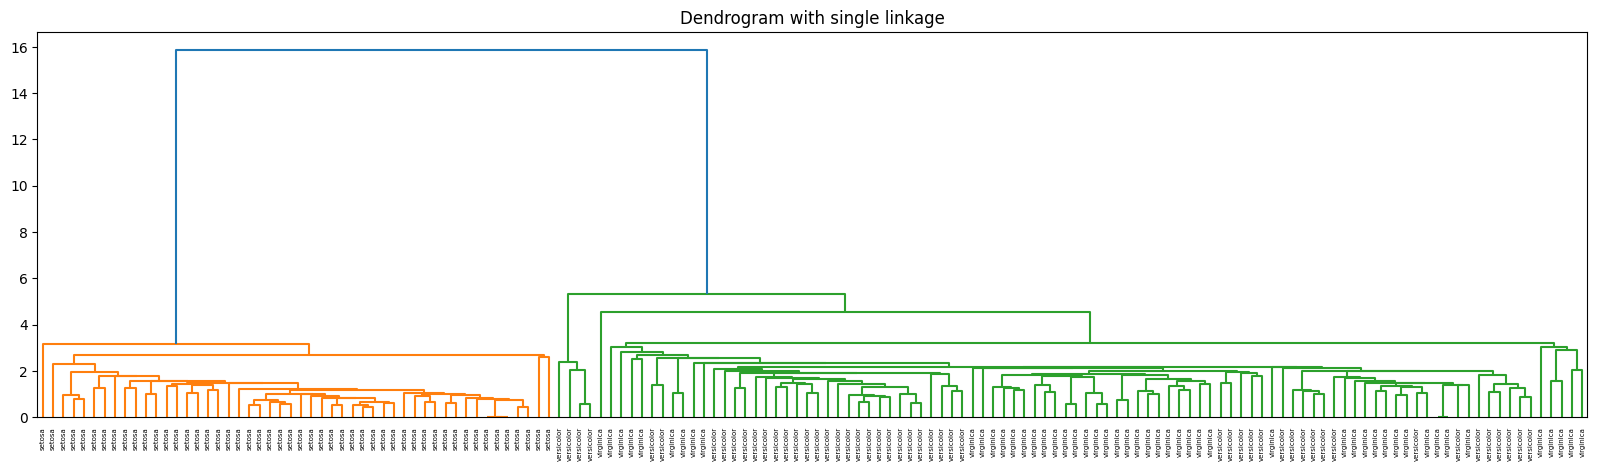

In [319]:
plt.figure(figsize=(20,5))
dendogram_simple = dendrogram(linkage(D_iris, method='single'), labels=df_iris['class'].values, orientation='top')
plt.title('Dendrogram with single linkage')

In [324]:
groups_simple = fcluster(linkage(D_iris, method='single'), 3, criterion='maxclust')
print(pd.crosstab(df_iris['class'], groups_simple))


col_0        1  2   3
class                
setosa      50  0   0
versicolor   0  4  46
virginica    0  0  50


C:\Users\nicol\AppData\Local\Temp\ipykernel_18296\2626837912.py:1: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  groups_simple = fcluster(linkage(D_iris, method='single'), 3, criterion='maxclust')


#### Complete Linkage

C:\Users\nicol\AppData\Local\Temp\ipykernel_18296\3752127100.py:2: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  dendogram_complete = dendrogram(linkage(D_iris, method='complete'), labels=df_iris['class'].values, orientation='top')


Text(0.5, 1.0, 'Dendrogram with complete linkage')

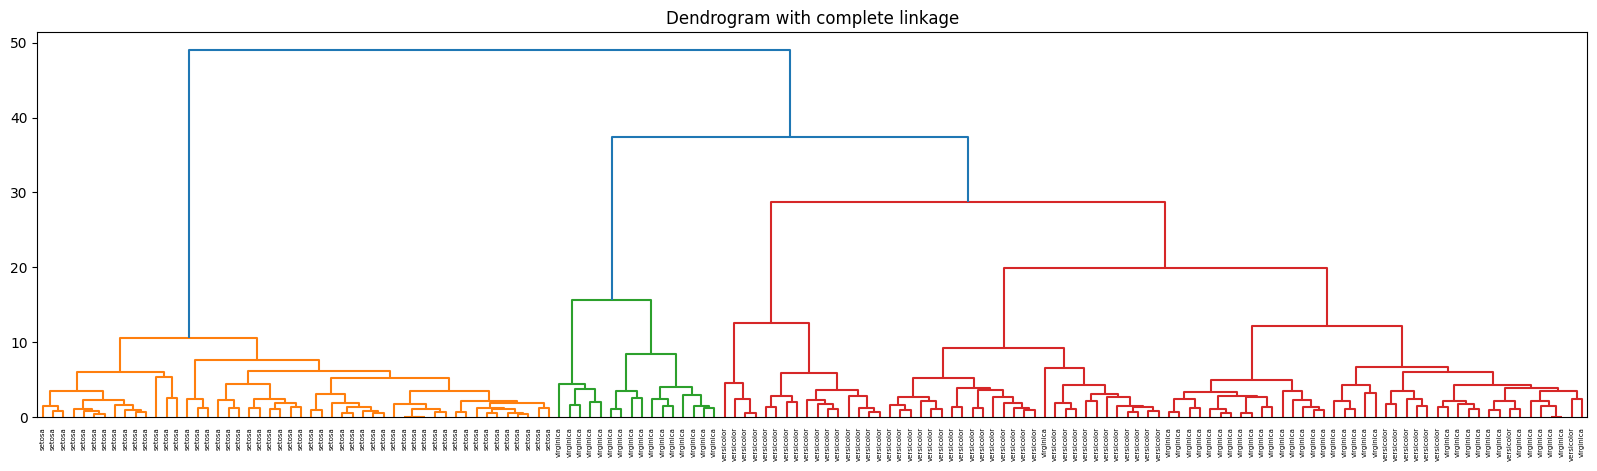

In [325]:
plt.figure(figsize=(20,5))
dendogram_complete = dendrogram(linkage(D_iris, method='complete'), labels=df_iris['class'].values, orientation='top')
plt.title('Dendrogram with complete linkage')

In [326]:
groups_complete = fcluster(linkage(D_iris, method='complete'), 3, criterion='maxclust')
print(pd.crosstab(df_iris['class'], groups_complete))

col_0        1   2   3
class                 
setosa      50   0   0
versicolor   0   0  50
virginica    0  16  34


C:\Users\nicol\AppData\Local\Temp\ipykernel_18296\567544541.py:1: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  groups_complete = fcluster(linkage(D_iris, method='complete'), 3, criterion='maxclust')


#### Ward Linkage

C:\Users\nicol\AppData\Local\Temp\ipykernel_18296\1796080830.py:3: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  dendogram_ward = dendrogram(linkage(D_iris, method='ward'), labels=df_iris['class'].values, orientation='top')


Text(0.5, 1.0, 'Dendrogram with ward linkage')

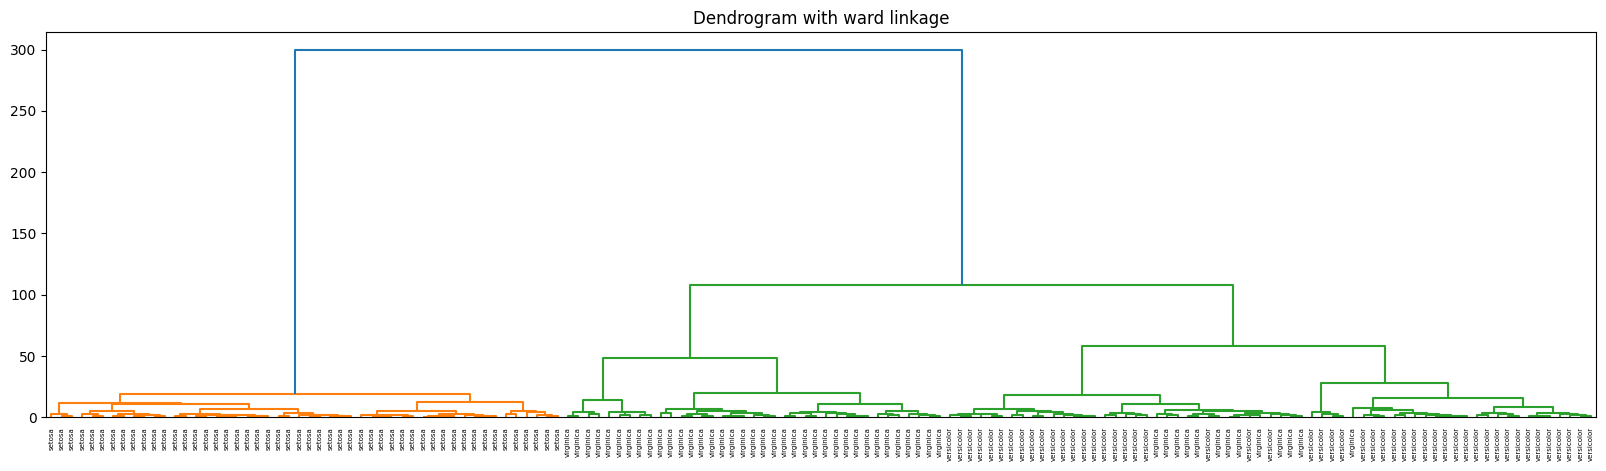

In [327]:
# use ward
plt.figure(figsize=(20,5))
dendogram_ward = dendrogram(linkage(D_iris, method='ward'), labels=df_iris['class'].values, orientation='top')
plt.title('Dendrogram with ward linkage')

In [328]:
groups_ward = fcluster(linkage(D_iris, method='ward'), 3, criterion='maxclust')
print(pd.crosstab(df_iris['class'], groups_ward))

col_0        1   2   3
class                 
setosa      50   0   0
versicolor   0   0  50
virginica    0  37  13


C:\Users\nicol\AppData\Local\Temp\ipykernel_18296\3785108084.py:1: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  groups_ward = fcluster(linkage(D_iris, method='ward'), 3, criterion='maxclust')


#### Centroid Linkage

C:\Users\nicol\AppData\Local\Temp\ipykernel_18296\2434488740.py:2: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  dendogram_centroid = dendrogram(linkage(D_iris, method='centroid'), labels=df_iris['class'].values, orientation='top')


Text(0.5, 1.0, 'Dendrogram with centroid linkage')

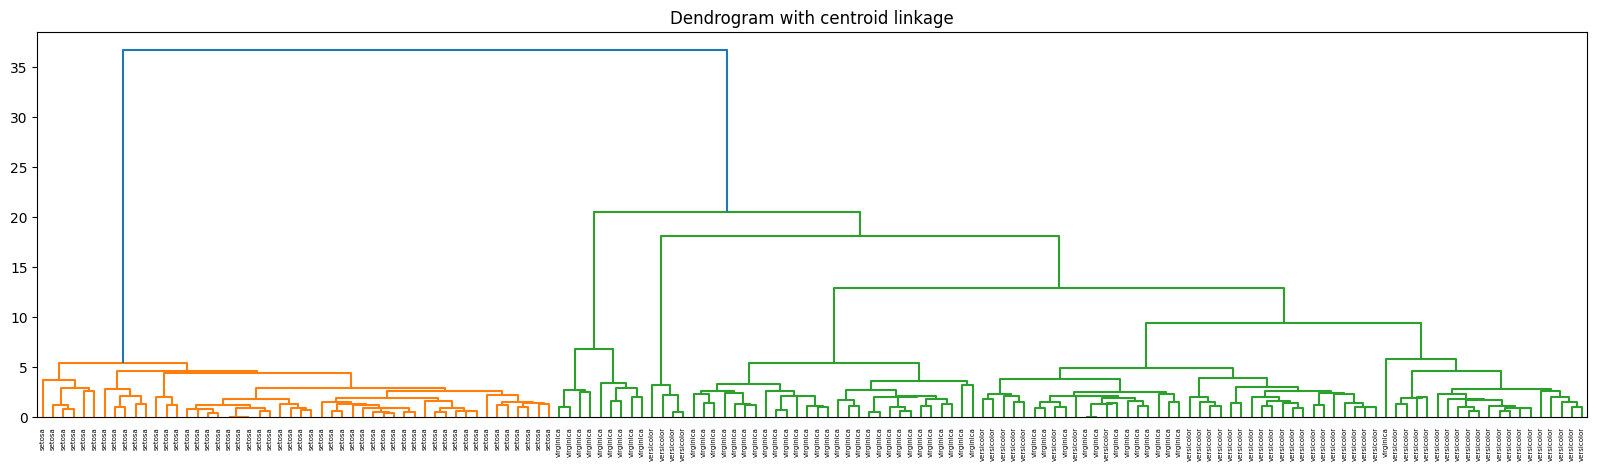

In [330]:
plt.figure(figsize=(20,5))
dendogram_centroid = dendrogram(linkage(D_iris, method='centroid'), labels=df_iris['class'].values, orientation='top')
plt.title('Dendrogram with centroid linkage')

In [331]:
groups_centroid = fcluster(linkage(D_iris, method='centroid'), 3, criterion='maxclust')
print(pd.crosstab(df_iris['class'], groups_centroid))

col_0        1  2   3
class                
setosa      50  0   0
versicolor   0  0  50
virginica    0  9  41


C:\Users\nicol\AppData\Local\Temp\ipykernel_18296\1680376151.py:1: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  groups_centroid = fcluster(linkage(D_iris, method='centroid'), 3, criterion='maxclust')


### Compare the results

In [333]:
print('\n Simple linkage')
print(pd.crosstab(df_iris['class'], groups_simple))

print('\n Average linkage')
print(pd.crosstab(df_iris['class'], groups_complete))

print('\n Complete linkage')
print(pd.crosstab(df_iris['class'], groups_ward))

print('\n Ward linkage')
print(pd.crosstab(df_iris['class'], groups_centroid))


 Simple linkage
col_0        1  2   3
class                
setosa      50  0   0
versicolor   0  4  46
virginica    0  0  50

 Average linkage
col_0        1   2   3
class                 
setosa      50   0   0
versicolor   0   0  50
virginica    0  16  34

 Complete linkage
col_0        1   2   3
class                 
setosa      50   0   0
versicolor   0   0  50
virginica    0  37  13

 Ward linkage
col_0        1  2   3
class                
setosa      50  0   0
versicolor   0  0  50
virginica    0  9  41


Any linkage method can perfectly detect `Setosa` flowers. When it comes to the `Virginica` class, complete and average linkage can't fully detect it, but ward and simple can easily do a good job. Finally, no linkage method can detect `Setosa` at all.